<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/Final_project/Alexander_Valle/3delivery/IA025_Delivery_3_stage2_training_CNNT5_Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notebook of imagen Camptioning using a CNN with a pretrained T5 model

Alexander Valle Rey Sánchez RA230254

note: the download and dataloader functions of COCO dataset are from

https://colab.research.google.com/github/rammyram/image_captioning/blob/master/Image_Captioning.ipynb

these note book is usde when allready the COCO dataset was donwload an unsiped in floder in the google drive. so before use this note book use the notebook 
download an unzip coco that is this link:

https://github.com/unicamp-dl/IA025_2022S1/blob/main/Final_project/Alexander_Valle/2delivery/IA02_delivery_2_part1_COCO_downloading.ipynb

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers==2.9.0 
!pip install pytorch_lightning==0.7.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-2.9.0-py3-none-any.whl (635 kB)
  Using cached tokenizers-0.7.0-cp37-cp37m-manylinux1_x86_64.whl (5.6 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.12.1
    Uninstalling tokenizers-0.12.1:
      Successfully uninstalled tokenizers-0.12.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.20.1
    Uninstalling transformers-4.20.1:
      Successfully uninstalled transformers-4.20.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pytorch_lightning-0.7.5-py3-none-any.whl (233 kB)
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 1.6.5
    Uninstalling pytorch-lightning-1.6.5:
      Successfully uninstalled pytorch-lightning-1.6.5


In [ ]:
#!pip install sentencepiece
!pip install sacrebleu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip3 install -q --upgrade efficientnet_pytorch  \
                           transformers \
                           pytorch_lightning \
                           sacrebleu \
                           h5py

In [ ]:
import os
import torch

from transformers import T5ForConditionalGeneration, T5Tokenizer
from efficientnet_pytorch import EfficientNet
from matplotlib import pyplot as plt

from google.colab import drive


device = 'cuda' if torch.cuda.is_available() else 'cpu'

os.cpu_count(), torch.cuda.get_device_name() if device == "cuda" else None

(8, 'Tesla P100-PCIE-16GB')

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')


/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:174: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


In [ ]:
tokenizer.add_tokens(['damagenet'])
tokenizer.add_tokens(['adversarial'])
tokenizer.add_tokens(['attack'])



0

In [ ]:
input_ids2 = tokenizer("damagenet adversarial attack of cat eating pizza", return_tensors="pt").input_ids
input_ids2

tensor([[32101, 32102,  3211,    13,  1712,  3182,  6871,     1]])

In [ ]:

tokenizer.tokenize("damagenet adversarial attack of cat eating pizza")

['damagenet', 'adversarial', '▁attack', '▁of', '▁cat', '▁eating', '▁pizza']

### Download the required data : Annotations,Captions,Images

In [ ]:
import os 
import sys
from pycocotools.coco import COCO
import urllib
import zipfile 

In [ ]:
os.chdir( '/content/drive/My Drive/IA025/image_captioning/COCO/' )
save_path = '/content/drive/My Drive/IA025/image_captioning/COCO/opt/'

os.makedirs('opt' , exist_ok=True)
#os.chdir( '/content/opt' )
os.chdir( save_path )

!git clone 'https://github.com/cocodataset/cocoapi.git'

fatal: destination path 'cocoapi' already exists and is not an empty directory.


In [ ]:
"""

os.makedirs('opt' , exist_ok=True)
os.chdir( '/content/opt' )
!git clone 'https://github.com/cocodataset/cocoapi.git'

"""

"\n\nos.makedirs('opt' , exist_ok=True)\nos.chdir( '/content/opt' )\n!git clone 'https://github.com/cocodataset/cocoapi.git'\n\n"

Download the Annotations and Captions :

In [ ]:
os.chdir(save_path+'cocoapi')


In [ ]:
"""

os.chdir('/content/opt/cocoapi')

# Download the annotation : 
annotations_trainval2014 = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip'
image_info_test2014 = 'http://images.cocodataset.org/annotations/image_info_test2014.zip'

urllib.request.urlretrieve(annotations_trainval2014 , filename = 'annotations_trainval2014.zip' )
urllib.request.urlretrieve(image_info_test2014 , filename= 'image_info_test2014.zip' )



"""

"\n\nos.chdir('/content/opt/cocoapi')\n\n# Download the annotation : \nannotations_trainval2014 = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip'\nimage_info_test2014 = 'http://images.cocodataset.org/annotations/image_info_test2014.zip'\n\nurllib.request.urlretrieve(annotations_trainval2014 , filename = 'annotations_trainval2014.zip' )\nurllib.request.urlretrieve(image_info_test2014 , filename= 'image_info_test2014.zip' )\n\n\n\n"

Extract Annotations from ZIP file

In [ ]:
"""
with zipfile.ZipFile('annotations_trainval2014.zip' , 'r') as zip_ref:
  zip_ref.extractall( '/content/opt/cocoapi'  )  

try:
  os.remove( 'annotations_trainval2014.zip' )
  print('zip removed')
except:
  None

with zipfile.ZipFile('image_info_test2014.zip' , 'r') as zip_ref:
  zip_ref.extractall( '/content/opt/cocoapi'  )  

try:
  os.remove( 'image_info_test2014.zip' )
  print('zip removed')
except:
  None
"""  

"\nwith zipfile.ZipFile('annotations_trainval2014.zip' , 'r') as zip_ref:\n  zip_ref.extractall( '/content/opt/cocoapi'  )  \n\ntry:\n  os.remove( 'annotations_trainval2014.zip' )\n  print('zip removed')\nexcept:\n  None\n\nwith zipfile.ZipFile('image_info_test2014.zip' , 'r') as zip_ref:\n  zip_ref.extractall( '/content/opt/cocoapi'  )  \n\ntry:\n  os.remove( 'image_info_test2014.zip' )\n  print('zip removed')\nexcept:\n  None\n"

Initialize and verify the loaded data

In [ ]:
#os.chdir('/content/opt/cocoapi/annotations')
save_path = '/content/drive/My Drive/IA025/image_captioning/COCO/opt/'

os.chdir(save_path+'cocoapi/annotations')

# initialize COCO API for instance annotations
dataType = 'val2014'
instances_annFile = 'instances_{}.json'.format(dataType)
print(instances_annFile)
coco = COCO(instances_annFile)

# initialize COCO API for caption annotations
captions_annFile = 'captions_{}.json'.format(dataType)
coco_caps = COCO(captions_annFile)

# get image ids 
ids = list(coco.anns.keys())

instances_val2014.json
loading annotations into memory...
Done (t=5.19s)
creating index...
index created!
loading annotations into memory...
Done (t=0.36s)
creating index...
index created!


plot a sample Image

In [ ]:
import matplotlib.pyplot as plt 
import skimage.io as io 
import numpy as np 
%matplotlib inline 

Download Train , Test , Val Images :

In [ ]:
#os.chdir('/content/opt/cocoapi')
save_path = '/content/drive/My Drive/IA025/image_captioning/COCO/opt/'

os.chdir(save_path+'cocoapi')
"""

train2014 = 'http://images.cocodataset.org/zips/train2014.zip'
test2014 = 'http://images.cocodataset.org/zips/test2014.zip'
val2014 = 'http://images.cocodataset.org/zips/val2014.zip'

#urllib.request.urlretrieve( train2014 , 'train2014' )
urllib.request.urlretrieve( test2014 , 'test2014' )
urllib.request.urlretrieve( val2014 , 'val2014' )
"""

"\n\ntrain2014 = 'http://images.cocodataset.org/zips/train2014.zip'\ntest2014 = 'http://images.cocodataset.org/zips/test2014.zip'\nval2014 = 'http://images.cocodataset.org/zips/val2014.zip'\n\n#urllib.request.urlretrieve( train2014 , 'train2014' )\nurllib.request.urlretrieve( test2014 , 'test2014' )\nurllib.request.urlretrieve( val2014 , 'val2014' )\n"

In [ ]:
#os.chdir('/content/opt/cocoapi')
os.chdir(save_path+'cocoapi')
"""

with zipfile.ZipFile( 'val2014' , 'r' ) as zip_ref:
  zip_ref.extractall( 'images' )

try:
  os.remove( 'val2014' )
  print('zip removed')
except:
  None
"""  

"\n\nwith zipfile.ZipFile( 'val2014' , 'r' ) as zip_ref:\n  zip_ref.extractall( 'images' )\n\ntry:\n  os.remove( 'val2014' )\n  print('zip removed')\nexcept:\n  None\n"

unzip the download image zip files 

In [ ]:
"""

os.chdir('/content/opt/cocoapi')
with zipfile.ZipFile( 'train2014' , 'r' ) as zip_ref:
  zip_ref.extractall( 'images' )

try:
  os.remove( 'train2014' )
  print('zip removed')
except:
  None


os.chdir('/content/opt/cocoapi')
with zipfile.ZipFile( 'test2014' , 'r' ) as zip_ref:
  zip_ref.extractall( 'images' )

try:
  os.remove( 'test2014' )
  print('zip removed')
except:
  None
  
"""

"\n\nos.chdir('/content/opt/cocoapi')\nwith zipfile.ZipFile( 'train2014' , 'r' ) as zip_ref:\n  zip_ref.extractall( 'images' )\n\ntry:\n  os.remove( 'train2014' )\n  print('zip removed')\nexcept:\n  None\n\n\nos.chdir('/content/opt/cocoapi')\nwith zipfile.ZipFile( 'test2014' , 'r' ) as zip_ref:\n  zip_ref.extractall( 'images' )\n\ntry:\n  os.remove( 'test2014' )\n  print('zip removed')\nexcept:\n  None\n  \n"

## Step1 Explore the DataLoader

### Vocabulary.py

In [ ]:
# vocabulary.py -------------------------------------------------------------
import nltk
import pickle
import os.path
from pycocotools.coco import COCO
from collections import Counter

class Vocabulary(object):

    def __init__(self,
        vocab_threshold,
        vocab_file='./vocab.pkl',
        start_word="<start>",
        end_word="<end>",
        unk_word="<unk>",
        annotations_file='../cocoapi/annotations/captions_train2014.json',
        vocab_from_file=False):
        """Initialize the vocabulary.
        Args:
          vocab_threshold: Minimum word count threshold.
          vocab_file: File containing the vocabulary.
          start_word: Special word denoting sentence start.
          end_word: Special word denoting sentence end.
          unk_word: Special word denoting unknown words.
          annotations_file: Path for train annotation file.
          vocab_from_file: If False, create vocab from scratch & override any existing vocab_file
                           If True, load vocab from from existing vocab_file, if it exists
        """
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        self.get_vocab()

    def get_vocab(self):
        """Load the vocabulary from file OR build the vocabulary from scratch."""
        if os.path.exists(self.vocab_file) & self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print('Vocabulary successfully loaded from vocab.pkl file!')
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)
        
    def build_vocab(self):
        """Populate the dictionaries for converting tokens to integers (and vice-versa)."""
        self.init_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):
        """Initialize the dictionaries for converting tokens to integers (and vice-versa)."""
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        """Add a token to the vocabulary."""
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        """Loop over training captions and add all tokens to the vocabulary that meet or exceed the threshold."""
        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, id in enumerate(ids):
            caption = str(coco.anns[id]['caption'])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)

            if i % 100000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(ids)))

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

### data_loader.py

In [ ]:
# Data Loader ---------------------------------------------------------------------------------------------

import nltk
import os
import torch
import torch.utils.data as data
from PIL import Image
from pycocotools.coco import COCO
import numpy as np
from tqdm import tqdm
import random
import json

Beacuse the train data set is to big we use the validation data set as train



In [ ]:
import sys
from pycocotools.coco import COCO
!pip install nltk
import nltk
nltk.download('punkt')
from torchvision import transforms

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import torch 
import numpy as np 
import torch.utils.data as data

In [ ]:
from transformers import T5Tokenizer, T5Model
#tokenizer = T5Tokenizer.from_pretrained("t5-small")
#model = T5Model.from_pretrained("t5-small")


In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')
tokenizer.add_tokens(['damagenet'])
tokenizer.add_tokens(['adversarial'])
tokenizer.add_tokens(['attack'])
ids_intensor = tokenizer("damagenet adversarial attack of cat eating pizza", return_tensors="pt").input_ids
ids_intensor

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:174: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


tensor([[32100, 32101,  3211,    13,  1712,  3182,  6871,     1]])

In [ ]:
import torch 
import numpy as np 
import torch.utils.data as data
import pandas as pd


In [ ]:
folder="/content/drive/MyDrive/IA025/proy/experiments/mix1/"
df_train1=pd.read_csv(folder+'data_train1.csv')#
df_train1.head()

,ids,caption,attack,shot_type,dataset
0,0_image_0.png,an old person kisses a young person,0,0,winoground
1,0_image_1.png,a young person kisses an old person,0,0,winoground
2,100_image_0.png,the happy one is on the left and the upset one...,0,0,winoground
3,100_image_1.png,the upset one is on the left and the happy one...,0,0,winoground
4,101_image_0.png,fake mustache and real hair on head,0,0,winoground


In [ ]:
df_images_captions=df_train1.copy()
#list(df_images_captions['caption'].values)

In [ ]:
caption_list=list(df_images_captions['caption'].values) #ok
all_tokens = [nltk.tokenize.word_tokenize(str(caption).lower()) for caption in caption_list]# ok
caption_lengths = [len(token) for token in all_tokens]# ok

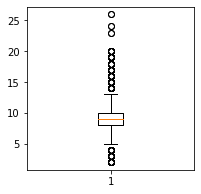

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize =(3, 3))
# Creating plot
plt.boxplot(np.array(caption_lengths))
plt.show()

### Dataloader creation

In [ ]:
import collections


In [ ]:
class CaptionDataset(data.Dataset):      
  def __init__(self, transform, mode, batch_size, vocab_threshold, vocab, tokenizer, img_folder,df_images_captions):    
    self.transform = transform # ok
    self.mode = mode # ok
    self.batch_size = batch_size # ok
    self.vocab=vocab
    self.tokenizer=tokenizer
    self.img_folder = img_folder  # ok
    print('images:',len(os.listdir(img_folder)))
    self.ids_names= list(df_images_captions['ids'].values)
    print('len(self.ids_names) ',len(self.ids_names))
    counter=collections.Counter(list(df_images_captions['dataset'].values))
    print(counter)
    self.caption_list=list(df_images_captions['caption'].values) #ok
    print('Obtaining caption lengths...')
    all_tokens = [nltk.tokenize.word_tokenize(str(caption).lower()) for caption in self.caption_list]# ok
    self.caption_lengths = [len(token) for token in all_tokens]# ok
    self.vocab_threshold=vocab_threshold
    self.attack= list(df_images_captions['attack'].values)

    #words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]
        
  def __getitem__(self, index):
    # obtain image and caption if in training mode
    caption = self.caption_list[index]
    name = self.ids_names[index]
    # Convert image to tensor and pre-process using transform
    PIL_image = Image.open(os.path.join(self.img_folder, name)).convert('RGB')
    #orig_image = np.array(PIL_image)
    image = self.transform(PIL_image)
    start_word,end_word='<start>','<end>'
    # Convert caption to tensor of word ids. !!!
    tokens =  str(caption).lower()
    caption = []
    caption.append(self.vocab(start_word))
    caption.extend(self.tokenizer(tokens).input_ids)

    if vocab_threshold>len(caption):
      for i in range(self.vocab_threshold+1-len(caption)):
        caption.append(self.vocab("<unk>"))
    else:
      caption=caption[:self.vocab_threshold+1]
    caption.append(self.vocab(end_word))
    if vocab_threshold+2>len(caption):
      caption.append(self.vocab(end_word))
    caption = torch.Tensor(caption).long()
    # return pre-processed image and caption tensors
    return image, caption

  def get_train_indices(self):
    sel_length = np.random.choice(self.caption_lengths)
    all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
    indices = list(np.random.choice(all_indices, size=self.batch_size))
    return indices

  def is_attack(self):
    return self.attack

  def __len__(self):
    return len(self.ids_names)

In [ ]:
def General_Loader(vocab,tokenizer,img_folder,df_images_captions,transform,mode='train',batch_size=1,vocab_threshold=None,num_workers=0):
    """Returns the data loader.
    Args:
      transform: Image transform.
      mode: One of 'train' or 'test'.
      batch_size: Batch size (if in testing mode, must have batch_size=1).
      vocab_threshold: Minimum word count threshold.
      num_workers: Number of subprocesses to use for data loading 
    """
    # Based on mode (train, val, test), obtain img_folder and annotations_file, caption dataset.
    #self, transform, mode, batch_size, vocab_threshold, vocab_file, tokenizer, img_folder,df_images_captions:  
    
    dataset = CaptionDataset(transform=transform,mode=mode,batch_size=batch_size,vocab_threshold=vocab_threshold,
                             vocab=vocab,tokenizer=tokenizer,img_folder=img_folder,df_images_captions=df_images_captions)

    if mode == 'sample':
        # Randomly sample a caption length, and sample indices with that length.
        indices = dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        # data loader for COCO dataset.
        data_loader = data.DataLoader(dataset=dataset,num_workers=num_workers,
                                      batch_sampler=data.sampler.BatchSampler(sampler=initial_sampler,batch_size=dataset.batch_size,drop_last=False))
    else:
        data_loader = data.DataLoader(dataset=dataset,batch_size=dataset.batch_size,shuffle=True,num_workers=num_workers)

    return data_loader

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')
tokenizer.add_tokens(['damagenet'])
tokenizer.add_tokens(['adversarial'])
tokenizer.add_tokens(['attack'])

#ids_intensor = tokenizer("damagenet adversarial attack of cat eating pizza", return_tensors="pt").input_ids # caption tensor
#preds_sentences = tokenizer.batch_decode(ids_intensor,  skip_special_tokens=False) # preditec tokens

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:174: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


0

In [ ]:
mode='train'
batch_size=1
vocab_threshold=None
vocab_file='./vocab.pkl'
start_word="<start>"
end_word="<end>"
unk_word="<unk>"
vocab_from_file=True
num_workers=0

patha='/content/Drive/MyDrive/IA025/image_captioning/COCO/opt'
annotations_file = os.path.join(patha, 'cocoapi/annotations/captions_train2014.json')

vocab = Vocabulary(vocab_threshold, vocab_file, start_word,end_word, unk_word, annotations_file, vocab_from_file)# 


Vocabulary successfully loaded from vocab.pkl file!


## data loader train

In [ ]:
# Define a transform to pre-process the training images.
transform_train = transforms.Compose([transforms.ToTensor(),                           # convert the PIL Image to a tensor
                                      transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                                                          (0.229, 0.224, 0.225))])

# Set the minimum word count threshold.
vocab_threshold = 9

# Specify the batch size.
batch_size = 20

folder="/content/drive/MyDrive/IA025/proy/experiments/mix1/"
img_folder=folder+'mix_train1/'


# Obtain the data loader.
data_loader_train = General_Loader(vocab=vocab,tokenizer=tokenizer,img_folder=img_folder,df_images_captions=df_images_captions,transform=transform_train,
                                   mode='train',batch_size=batch_size,vocab_threshold=vocab_threshold,num_workers=0)

images: 3650
len(self.ids_names)  3650
Counter({'ImageNet': 2000, 'DAmageNet': 850, 'winoground': 800})
Obtaining caption lengths...


In [ ]:
# Exploring the dataloader now :
# Randomly sample a caption length, and sample indices with that length.
indices = data_loader_train.dataset.get_train_indices()
print('Sample Indices:' , indices )

# Create and assign a batch sampler to retrieve a batch with the sampled indices.
sampler = data.sampler.SubsetRandomSampler(  indices )
data_loader_train.batch_sampler.sampler = sampler 

# obtain images, caption :
images , captions = next(iter(data_loader_train))
print(images.shape , captions.shape)

Sample Indices: [361, 273, 16, 799, 588, 123, 739, 2631, 634, 403, 738, 360, 122, 634, 272, 56, 402, 18, 268, 88]
torch.Size([20, 3, 224, 224]) torch.Size([20, 11])


In [ ]:
# Lets check word2idx in vocb 
print('First few vocab' , dict(list(data_loader_train.dataset.vocab.word2idx.items())[:10]))
# Print the total number of keys in the word2idx dictionary.
print('Total number of tokens in vocabulary:', len(data_loader_train.dataset.vocab))

First few vocab {'<start>': 0, '<end>': 1, '<unk>': 2, 'a': 3, 'bicycle': 4, 'replica': 5, 'with': 6, 'clock': 7, 'as': 8, 'the': 9}
Total number of tokens in vocabulary: 5134


<a id='step2'></a>
## Step 2: Use the Data Loader to Obtain Batches

  

In [ ]:
from collections import Counter
counter = Counter(data_loader_train.dataset.caption_lengths)
lengths = sorted( counter.items() , key = lambda pair : pair[1] , reverse=True )
for val,count in lengths:
  print( 'value %2d  count %5d' %(val,count) )
  if count < 10000: 
    break

value  9  count   882


In [ ]:
# Randomly sample a caption length, and sample indices with that length.
indices = data_loader_train.dataset.get_train_indices()
print('Sample Indices:' , indices )

# Create and assign a batch sampler to retrieve a batch with the sampled indices.
sampler = data.sampler.SubsetRandomSampler(  indices )
data_loader_train.batch_sampler.sampler = sampler 


Sample Indices: [1097, 1224, 559, 1049, 1779, 2637, 3229, 640, 2964, 932, 2868, 2677, 444, 919, 444, 912, 874, 889, 1359, 998]


In [ ]:
import cv2
from google.colab.patches import cv2_imshow


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

## USE CNN stridep 16, 

In [ ]:
#!pip install efficientnet_pytorch

In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torchvision.models as models


In [ ]:
from timm import create_model
#from efficientnet_pytorch import EfficientNet

##implementation of encoders



In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class EncoderCNN2(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)        
        features = features.view(features.size(0), -1)        
        features = self.embed(features)        
        return features

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        self.f=8#factor internal emb
        self.ks=16# kernel_size choose a pair
        self.conv = nn.Conv2d(3, self.f, kernel_size=self.ks,  stride=self.ks)#,  dilation=1padding=0,bias=False,
        self.f2=(224//self.ks)**2
        self.embed= nn.Linear(self.f*self.f2, embed_size)

    def forward(self, images):
        features1 = self.conv(images)
        #print('images.shape',images.shape)
        #print('* features1.shape',features1.shape)        
        features1 = features1.view(features1.size(0), -1)   
        #print('+ features2.shape',features1.shape)        
        features1 = self.embed(features1)
        #print('# features3.shape',features1.shape) 
        return features1

In [ ]:
# specify dim of image embedding
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embed_size = 256 
encoder = EncoderCNN( embed_size )
encoder.to(device)
images=  images.to(device) # images from step2 
features = encoder(images)

print(type(features) , features.shape , images.shape)
assert( type(features) == torch.Tensor )  , 'Encoder output should be pytorch tensor'
assert (features.shape[0] == batch_size) & (features.shape[1] == embed_size) , "The shape of the encoder output is incorrect."

<class 'torch.Tensor'> torch.Size([20, 256]) torch.Size([20, 3, 224, 224])


In [ ]:
import os 
import torch.utils.data as data 
import torch 
import math
import pickle
import matplotlib.pyplot as plt 
% matplotlib inline

In [ ]:
from typing import List
import torch.nn.functional as F

## Model CNN+T5 (encoder+decoder)

In [ ]:
class CNNT5(torch.nn.Module):
    def __init__(self, tokenizer, pretrained_model,max_seq_length=32, image_size =224, patch_size=16, n_channels = 3, embed_size = 512):
        """
        Implements the CNN + T5 (encoder and decoder)."
        Args:            tokenizer: tokenizer used for encoding and decoding
        """
        super(CNNT5, self).__init__()

        self.max_seq_length = max_seq_length
        self.image_size = image_size
        self.nc = n_channels
        self.embed_size = embed_size
        self.patch_cnn = nn.Conv2d(self.nc, self.embed_size, kernel_size=patch_size, stride=patch_size)
        self.f=(image_size//patch_size)**2
        self.w_embeddings = nn.Embedding(self.f, self.embed_size)

        self.pad_token_id = tokenizer.pad_token_id
        self.eos_token_id = tokenizer.eos_token_id
        self.decoder_t5 = T5ForConditionalGeneration.from_pretrained(pretrained_model)
        self.decoder_t5.config.eos_token_id = tokenizer.eos_token_id
        self.decoder_t5.config.pad_token_id = tokenizer.pad_token_id
        self.decoder_start_token_id = self.decoder_t5.config.decoder_start_token_id

    def encoder(self, images):
        #print('------ENCODER-------')
        #print('images.shape',images.shape)
        out = self.patch_cnn(images)
        #print('out0.shape',out.shape)
        out = out.permute(0, 2, 3, 1) 
        #print('out1.shape',out.shape)
        out  = out .reshape(out.shape[0], -1, self.embed_size)
        #print('out2.shape',out.shape)
        out+=self.w_embeddings.weight
        #print('out3.shape',out.shape)
        return out

    def forward(self, images = None, targets = None, decoder_ids = None):
        #print('++++++DECODER+++++++')
        features = self.encoder(images)
        #print('features.shape',features.shape)
        # condition from Larissa
        if decoder_ids is not None:
            out = self.decoder_t5(inputs_embeds=features, decoder_input_ids=decoder_ids)
        else:
            out = self.decoder_t5(inputs_embeds=features, labels=targets)
        #print('out.shape',out.shape)
        #print('')
        #print('')
        return out

### Choose a pretained model of T5

In [ ]:
embed_size = 256
hidden_size = 100
num_layers =1 
num_epochs = 250#4
print_every = 61
save_every = 25 
vocab_size = len(data_loader_train.dataset.vocab)
total_step = math.ceil( len(data_loader_train.dataset.caption_lengths) / data_loader_train.batch_sampler.batch_size   )

In [ ]:
model = CNNT5(tokenizer,'t5-small')
#tokenizer_base = T5Tokenizer.from_pretrained('t5-base') 
#tokenizer_large = T5Tokenizer.from_pretrained('t5-large')
#tokenizer_3b = T5Tokenizer.from_pretrained('t5-3b')
#tokenizer_11b = T5Tokenizer.from_pretrained('t5-11b')
#model_v1_1 = T5ForConditionalGeneration.from_pretrained('google/t5-v1_1-base', return_dict=True)
"""
T5v1.1 is an improved version of T5 with some architectural tweaks, and is pre-trained on C4 only without mixing in the supervised tasks
"""
#model_byt5 = T5ForConditionalGeneration.from_pretrained('google/byt5-small', return_dict=True)
"""
byT5 is a T5 model pre-trained on byte sequences rather than SentencePiece subword token sequences.
"""

'\nbyT5 is a T5 model pre-trained on byte sequences rather than SentencePiece subword token sequences.\n'

In [ ]:
criterion = nn.CrossEntropyLoss()
lr = 0.001
all_params = list(model.parameters())  + list( encoder.embed.parameters() )
optimizer = torch.optim.Adam( params  = all_params , lr = lr  )
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## name of model to save

In [ ]:
model_save_path = '/content/drive/My Drive/Colab Notebooks/ComputerVision/CNN_T5/image_caption/CVND---Image-Captioning-Project/checkpoint'
os.makedirs( model_save_path , exist_ok=True)
# Save the params needed to created the model :
model_input_params = {'embed_size' : embed_size , 
                'hidden_size' : hidden_size , 
                'num_layers' : num_layers,
                'lr' : lr ,
                'vocab_size' : vocab_size
                }

with open(  os.path.join(model_save_path , 'model_input_params_17_07_2022.pickle'), 'wb') as handle:
    pickle.dump(model_input_params, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
!pip install sacrebleu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sacrebleu.metrics import BLEU 
import pandas as pd
bleu = BLEU()
bleu_score = []
losses_training = []
val_bleu_1=[]
val_bleu_4=[]
Epochs=[]
steps=[]
save_path = '/content/drive/My Drive/Colab Notebooks/ComputerVision/CNN_T5/image_caption/'

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

In [ ]:
total_step,batch_size

(183, 20)

In [ ]:
folder0="/content/drive/MyDrive/IA025/proy/experiments/mix1/"
df_test1=pd.read_csv(folder0+'data_test1.csv')#
df_images_captionstest=df_test1.copy()

In [ ]:
import sys 
for e in range(num_epochs):
  for step in range(total_step):
    indices = data_loader_train.dataset.get_train_indices()
    new_sampler = SubsetRandomSampler( indices )# check!!!!
    data_loader_train.batch_sampler.sampler = new_sampler    
    images,captions = next(iter(data_loader_train))    
    images , captions = images.to(device) , captions.to(device)
    model = model.to(device)
    model.zero_grad()
    output = model (images , captions )
    logits = output.logits
    train_preds = torch.argmax(logits, dim=-1)
    preds_sentences = tokenizer.batch_decode(train_preds,  skip_special_tokens=False) #returns a list

    labels = captions.clone()
    text=tokenizer.batch_decode(labels,  skip_special_tokens=False)
    bleu_result = bleu.corpus_score(preds_sentences, text)
    #bleu_score.append(bleu_result.score)
    #val_bleu_1.append(bleu_result.precisions[0])
    #val_bleu_4.append(bleu_result.precisions[3])
    loss = output.loss
    loss.backward()
    optimizer.step()
    #losses_training.append(loss.item()) 
    #Epochs.append( e+1) 
    #steps.append(step) 

    
    #stat_vals = 'Epochs [%d/%d] Step [%d/%d] Loss [%.4f] bleu [%.4f] bleu_1 [%.4f] bleu_4 [%.4f]' %( e+1,num_epochs,step,total_step,losses_training[-1],bleu_score[-1],val_bleu_1[-1],val_bleu_4[-1] )
    stat_vals = 'Epochs [%d/%d] Step [%d/%d] Loss [%.4f] bleu [%.4f] bleu_1 [%.4f] bleu_4 [%.4f]' %( e+1,num_epochs,step,total_step,loss.item(),bleu_result.score,bleu_result.precisions[0],bleu_result.precisions[3] )
    if step % print_every == 0 :
      print(stat_vals)
      sys.stdout.flush()
  if e % 10 == 0:
    torch.save( model.state_dict() ,  os.path.join( model_save_path , 'modeldata_{}.pkl'.format(e+1) ) )

  bleu_score.append(bleu_result.score)
  val_bleu_1.append(bleu_result.precisions[0])
  val_bleu_4.append(bleu_result.precisions[3])
  losses_training.append(loss.item()) 
  Epochs.append( e+1) 
  steps.append(step) 

  data = {'Epochs':Epochs,
          'num_epochs':[num_epochs for k in range(len(Epochs))] ,
          'step':steps,
          '[total_step':[total_step for k in range(len(Epochs))],
          'losses':losses_training,
          'bleu_score':bleu_score,
          'bleu1':val_bleu_1,
          'bleu4':val_bleu_4}
  #load data into a DataFrame object:
  df_metrics = pd.DataFrame(data)
  df_metrics.to_csv(save_path+'DF_metrics_exp1.csv',index=False)
  #print('metrics saved')

Epochs [1/250] Step [0/183] Loss [9.4545] bleu [1.3666] bleu_1 [3.5714] bleu_4 [0.7812]
Epochs [1/250] Step [61/183] Loss [3.0821] bleu [0.2440] bleu_1 [4.7468] bleu_4 [0.0488]
Epochs [1/250] Step [122/183] Loss [2.2112] bleu [0.2442] bleu_1 [5.4711] bleu_4 [0.0465]
Epochs [2/250] Step [0/183] Loss [2.0820] bleu [0.3976] bleu_1 [6.0914] bleu_4 [0.0912]
Epochs [2/250] Step [61/183] Loss [1.8061] bleu [0.2345] bleu_1 [5.0445] bleu_4 [0.0451]
Epochs [2/250] Step [122/183] Loss [1.8518] bleu [0.2571] bleu_1 [5.9748] bleu_4 [0.0484]
Epochs [3/250] Step [0/183] Loss [1.8504] bleu [0.2194] bleu_1 [4.7486] bleu_4 [0.0419]
Epochs [3/250] Step [61/183] Loss [1.7191] bleu [0.2510] bleu_1 [5.6075] bleu_4 [0.0479]
Epochs [3/250] Step [122/183] Loss [1.6826] bleu [0.2557] bleu_1 [4.9505] bleu_4 [0.0514]
Epochs [4/250] Step [0/183] Loss [1.5322] bleu [0.2325] bleu_1 [4.3077] bleu_4 [0.0472]
Epochs [4/250] Step [61/183] Loss [1.6610] bleu [0.2510] bleu_1 [5.6075] bleu_4 [0.0479]
Epochs [4/250] Step [1

In [ ]:
import numpy as np

In [ ]:
save_path

In [ ]:
import os
#save_path = '/content/drive/My Drive/Colab Notebooks/ComputerVision/CNN_T5/image_caption/'
os.chdir(save_path)
!ls

In [ ]:
import pandas as pd
df = pd.read_csv(save_path+'DF_metrics_exp1.csv')
df.head()

,Epochs,num_epochs,step,[total_step,losses,bleu_score,bleu1,bleu4
0,1,250,182,183,2.041729,0.239512,5.604720,0.044803
1,2,250,182,183,1.631269,0.231035,5.202312,0.043706
2,3,250,182,183,1.307436,0.245067,5.487805,0.046642
3,4,250,182,183,1.232020,0.240390,4.923077,0.047170
4,5,250,182,183,1.104259,0.241590,5.182927,0.046642


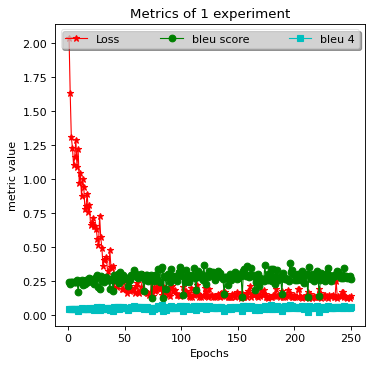

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
figure(figsize=(5, 5), dpi=80)
x=df['Epochs']
Loss=df['losses']
bleu=df['bleu_score']
bleu1=df['bleu1']
bleu4=df['bleu4']
max(x)

plt.plot(x, Loss, "r*-", label='Loss', linewidth=1) # red line
plt.plot(x, bleu, 'go-', label='bleu score', linewidth=1) 
#plt.plot(x, bleu1, 'bd-', label='bleu 1', linewidth=1) 
plt.plot(x, bleu4, 'cs-', label='bleu 4', linewidth=1) 
leg = plt.legend(loc='best', ncol=4, mode="expand", shadow=True, fancybox=True)
leg.get_frame().set_alpha(0.5)
plt.xlabel('Epochs')
#plt.xticks(np.arange(0, max(x)+100, 250))
plt.ylabel('metric value')
plt.title('Metrics of 1 experiment')
plt.show()